In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [16]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [23]:
model = ChatOpenAI()

structured_model1 = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

D:\Data Science\My Projects\Langgraph Tutorials\venv\lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [45]:
def analyze_sentiment(state: ReviewState):
    prompt = f'Analyze sentiment of the following review: {state["review"]}'
    sentiment = structured_model1.invoke(prompt).sentiment
    return {"sentiment": sentiment}

def positive_response(state: ReviewState):
    prompt = f'Generate a positive response for the customer to the following review: {state["review"]}'
    response = model.invoke(prompt).content
    return {"response": response}

def run_diagnosis(state: ReviewState):
    prompt = f"Analyse the negative review: {state['review']} and return issue_type, tone, and urgency."
    response = structured_model2.invoke(prompt)
    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = (
        f"You are a support assistant. The user had a '{diagnosis['issue_type']}' issue, "
        f"sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'. "
        f"Write an empathetic, helpful resolution message."
    )
    response = model.invoke(prompt).content
    return {"response": response}

def check_sentiment(state: ReviewState):
    response = state['sentiment']
    if response == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"

In [46]:
graph = StateGraph(ReviewState)

graph.add_node("analyze_sentiment", analyze_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

graph.add_edge(START, "analyze_sentiment")
graph.add_conditional_edges("analyze_sentiment", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow2 = graph.compile()

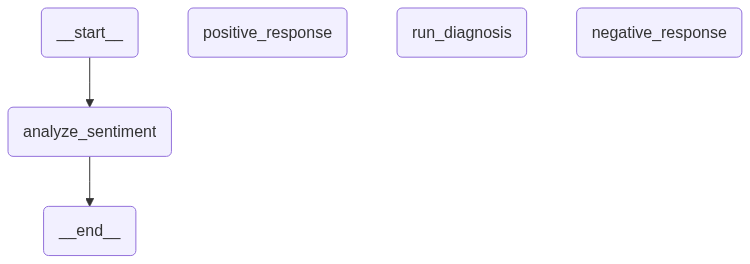

In [47]:
workflow2

In [48]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow2.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "I'm really sorry to hear that you're experiencing a bug issue, and I understand how frustrating that must be. I will prioritize this issue with the highest urgency and escalate it to our technical team immediately. Rest assured, we will work diligently to resolve this issue as quickly as possible. Thank you for bringing it to our attention. We appreciate your patience and understanding."}